# KDE Plots

The purpose of this notebook is to reproduce figures presenting results from our interval statistics analysis using BChron age models. Here we show the application of interval statistic techniques to the median interval values.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pyleoclim as pyleo

from matplotlib.lines import Line2D
from matplotlib import gridspec

In [2]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

# Sort by latitude

lat_dict = {pos_dict[label]['lat']:label for label in holo_chrons.keys()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
holo_chrons = {label:holo_chrons[label] for label in sort_label} #Sort by latitude
pos_dict = {label:pos_dict[label] for label in sort_label}

In [3]:
#Add an idealized surrogate ensemble with a spike for reference purposes

# define the function of a spike
def spike(t,delta,A):
    ''' Function to create a spike
        t : float
            time
        A : float
            amplitude
        delta : float
            parameter for the curve'''
    f=1/(2*(len(t)-1))
    y = (A/np.arctan(1/delta))*np.arctan(np.sin(2*np.pi*t*f)/delta)
    return y

def add_spike(series,xstart,xend,A,method='smooth'):
    '''Function to add a spike to a pyleoclim series
    
    Parameters
    ----------

        series : pyleo.Series; 
            the series to which the spike will be added
        xstart : float
            the starting year of the spike
        xend : float
            the ending year of the spike
        A : float
            the amplitude of the spike
        method : str
            "smooth": add a spike by spike;
            otherwise, directly add values of A at each timestep'''
    new_series = series.copy()
    x = new_series.time
    y = new_series.value
    if method=='smooth':
        y[(x>=xstart)&(x<=xend)] += spike(np.arange(0,sum((x>=xstart)&(x<=xend))),0.02,A)
    else:
        y[(x>=xstart)&(x<=xend)] += [(x>=xstart)&(x<=xend)]+np.full(xend-xstart+1,A)
    new_series.value = y
    return new_series

# # surr= pyleo.SurrogateSeries(method='ar1sim',seed=42,number=1000)
# # surr.from_param(param=[1,2],length=1000,time_pattern='random')

# time = pyleo.utils.random_time_axis(n=1000) + 3500
# value = np.random.standard_normal(len(time))
# series = pyleo.Series(time,value)
# new_series = add_spike(series,3900,4100,1)
    
# holo_chrons['Idealized'] = {}
# holo_chrons['Idealized']['d18O'] = new_series.value
# holo_chrons['Idealized']['chron'] = np.array([pyleo.utils.random_time_axis(n=1000)+3500 for _ in range(1000)])

In [4]:
# detrending and collect d18O values at different intervals

#d18O values at different intervals
d18O_int={}
#Detrended zscore vals
zscore_detrend={}

for site in holo_chrons.keys():
    ty = holo_chrons[site]['d18O'].astype(float)
    chron_tmp = holo_chrons[site]['chron'].astype(float)
    nC = 1000

    zscore_detrend[site]=np.zeros((nC,len(ty)))
    zscore_detrend[site][:]=np.nan
    
    for j in range(nC):
        tx=chron_tmp[j,:]
        # detrending by the Pyleoclim detrending function
        ts = pyleo.Series(time=tx, value=ty,dropna=False,verbose=False)
        if site != 'Idealized':
            ts_detrended= ts.detrend(method='savitzky-golay')
            a=ts_detrended.value
            zscore_detrend[site][j,:] = zscore(a,nan_policy='omit')
        else:
            a=ts.value
            zscore_detrend[site][j,:] = a

    d18O_int[site]={}
    holo_int={}
    # int_size: interval size
    for int_size in [150,200]:
        holo_int[int_size] = np.arange(4000%int_size-int_size/2,10000,int_size)
        d18O_int[site][int_size]=np.zeros((len(holo_int[int_size])-1,nC))
        d18O_int[site][int_size][:]=np.nan
        # iterate over each interval
        for idx,tage in enumerate(holo_int[int_size][:-1]):
            for j in range(nC):
                tx = chron_tmp[j,:]
                #calculate median interval value for each chron
                d18O_int[site][int_size][idx,j]=np.nanmedian(zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][idx+1])])

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_63628/2646092731.py:40: RuntimeWarning: All-NaN slice encountered
  d18O_int[site][int_size][idx,j]=np.nanmedian(zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][idx+1])])
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: R

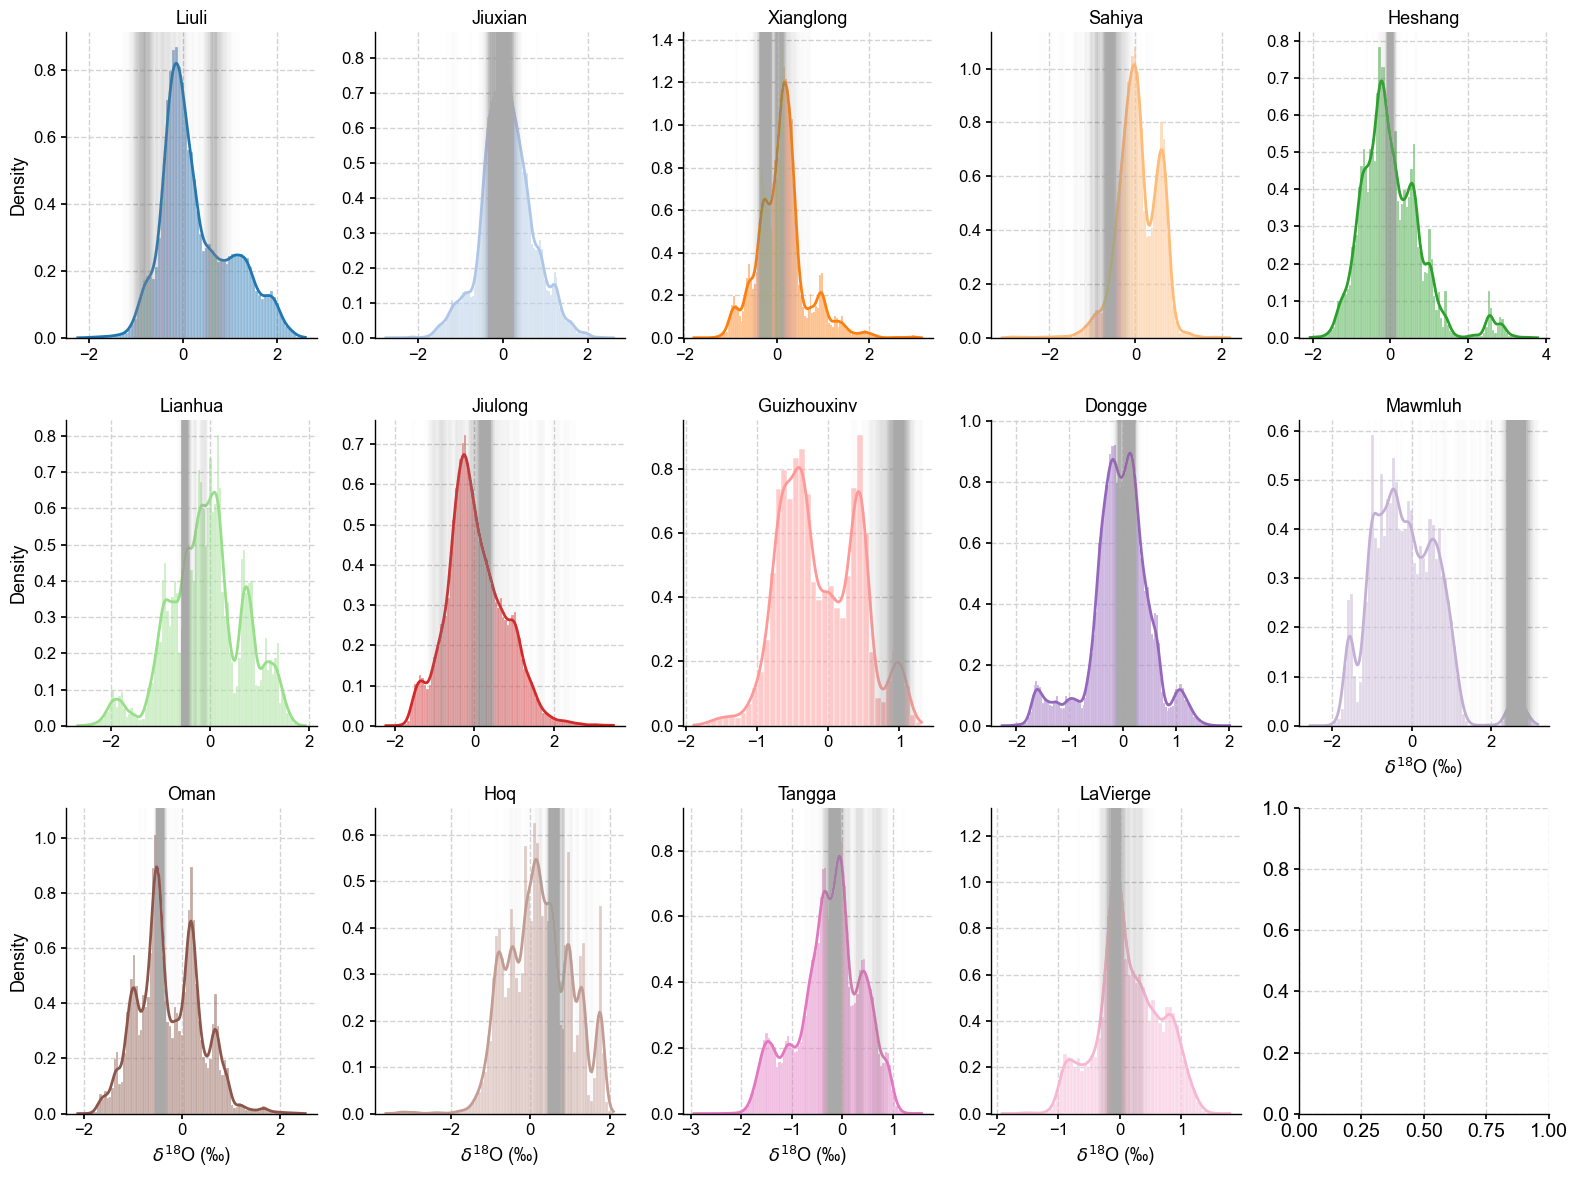

In [5]:
# Plotting

# Set color palette based on the number of keys in holo_chrons
clrs = sns.color_palette(palette='tab20', n_colors=len(holo_chrons.keys()) + 1)
clrs[14] = '#FFD700' # Make the last color gold

# Create a figure with 5 columns and 3 rows of subplots
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 12), tight_layout=True)

# Flatten the 2D array of axes into a 1D array
axes = ax.ravel()

int_size = 200

# Iterate over each site in holo_chrons
for idx, site in enumerate(holo_chrons.keys()):
    # Create a pandas Series from the flattened d18O_int for the current site and interval size
    s = pd.Series(d18O_int[site][int_size].flatten())

    # Plot a histogram with KDE for the current site
    sns.histplot(s.dropna(), color=clrs[idx], ax=axes[idx], kde=True, ec='white', stat='density')

    # Set the title of the subplot
    axes[idx].set_title(site, fontsize=13)

    # Set the y-label for specific subplots
    if idx in [0, 5, 10]:
        axes[idx].set_ylabel('Density', fontsize=13)
    else:
        axes[idx].set_ylabel('')

    # Set the tick label size for both axes
    axes[idx].tick_params(axis='both', which='major', labelsize=12)

    # Set the x-label for the bottom row of subplots
    if idx >= 9:
        axes[idx].set_xlabel(u'$\delta^{18}$O (\u2030)', fontsize=13)

    if idx == 14:
        # Add a legend to the last subplot
        axes[idx].set_xlim(-.5,1)

    # Iterate over each column in d18O_int for the current site and interval size
    for i in range(d18O_int[site][int_size].shape[1]):
        # Add a vertical line at the specified x-value with low opacity
        axes[idx].axvline(x=d18O_int[site][int_size][holo_int[int_size][:-1] == 4000 - int_size / 2, i], alpha=0.01, color='darkgray')

# # Remove the last unused subplot
# fig.delaxes(axes[-1])

In [6]:
with open('../../data/synthetic_signal_dict.pkl','rb') as handle:
    sn_signal_dict = pickle.load(handle)

In [7]:
# detrending and collect d18O values at different intervals
sn_ratios = list(sn_signal_dict.keys())
sn_int = {ratio : {} for ratio in sn_ratios}
sn_interval = {ratio : {} for ratio in sn_ratios}

for sn in [0.5,1,2,3]:
    #d18O values at different intervals
    syn_d18O_int={}
    #Detrended zscore vals
    syn_zscore_detrend={}
    # d18O values over the 4ka interval
    syn_interval_dict = {}
    signal_dict = sn_signal_dict[sn]

    for site in signal_dict.keys():
        ty = sn_signal_dict[sn][site]
        chron_tmp = holo_chrons[site]['chron'].astype(float)
        nC = 1000

        syn_zscore_detrend[site]=np.zeros((nC,len(ty)))
        syn_zscore_detrend[site][:]=np.nan
        
        for j in range(nC):
            tx=chron_tmp[j,:]
            # detrending by the Pyleoclim detrending function
            ts = pyleo.Series(time=tx, value=ty,dropna=False,verbose=False)
            if site != 'Idealized':
                ts_detrended= ts.detrend(method='savitzky-golay')
                a=ts_detrended.value
                syn_zscore_detrend[site][j,:] = zscore(a,nan_policy='omit')
            else:
                a=ts.value
                syn_zscore_detrend[site][j,:] = a

        syn_d18O_int[site]={}
        syn_interval_dict[site] = []
        holo_int={}
        # int_size: interval size
        for int_size in [150,200]:
            holo_int[int_size] = np.arange(4000%int_size-int_size/2,10000,int_size)
            syn_d18O_int[site][int_size]=np.zeros((len(holo_int[int_size])-1,nC))
            syn_d18O_int[site][int_size][:]=np.nan
            # iterate over each interval
            for idx,tage in enumerate(holo_int[int_size][:-1]):
                for j in range(nC):
                    tx = chron_tmp[j,:]
                    #calculate median interval value for each chron
                    syn_d18O_int[site][int_size][idx,j]=np.nanmedian(syn_zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][idx+1])])
            # Iterate over the columns of d18O_int for the current site and interval size
            for i in range(syn_d18O_int[site][int_size].shape[1]):
                # Append the d18O values at the 4ka interval to interval_dict
                syn_interval_dict[site].append(syn_d18O_int[site][int_size][holo_int[int_size][:-1] == 4000 - int_size / 2, i])
    sn_int[sn] = syn_d18O_int
    sn_interval[sn] = syn_interval_dict

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_63628/254292701.py:48: RuntimeWarning: All-NaN slice encountered
  syn_d18O_int[site][int_size][idx,j]=np.nanmedian(syn_zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][idx+1])])
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:

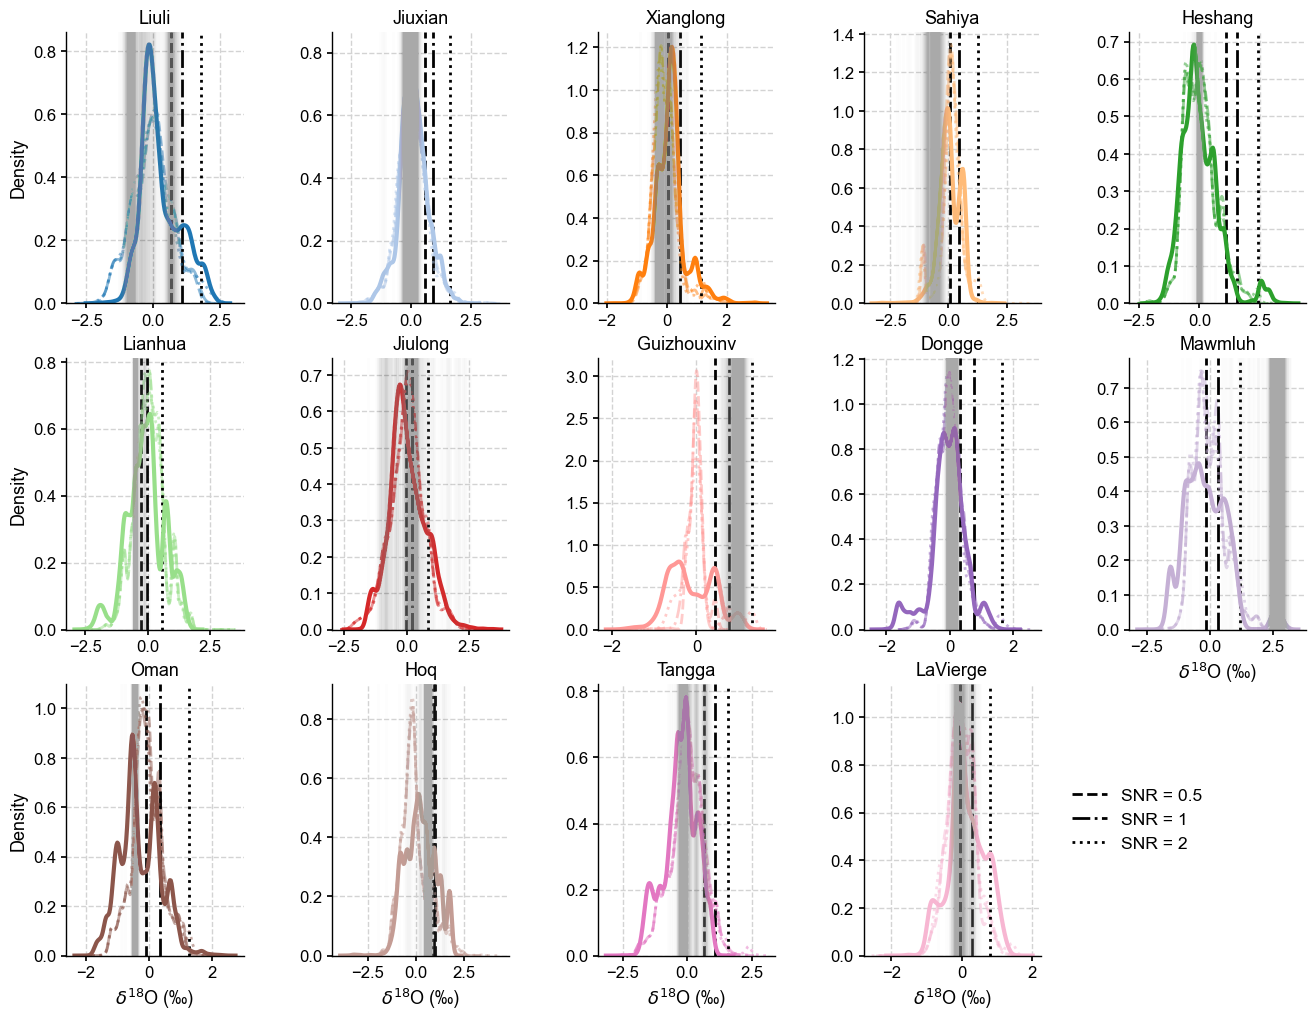

In [8]:
# Plotting

# Set color palette based on the number of keys in holo_chrons
clrs = sns.color_palette(palette='tab20', n_colors=len(holo_chrons.keys()) + 1)
clrs[14] = '#FFD700' # Make the last color gold
linestyles= ['dashed','dashdot','dotted']

# # Create a figure with 5 columns and 3 rows of subplots
# fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 12), tight_layout=True)
# fig.subplots_adjust(hspace=1, wspace=-.1)

# # Flatten the 2D array of axes into a 1D array
# axes = ax.ravel()

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 5, hspace=0.2, wspace=0.5)

int_size = 200
syn_d18O_int = sn_int[2]
# Iterate over each site in holo_chrons
for idx, site in enumerate(holo_chrons.keys()):
    ax = fig.add_subplot(gs[idx])
    # Create a pandas Series from the flattened d18O_int for the current site and interval size
    s = pd.Series(d18O_int[site][int_size].flatten())

    for idy,sn in enumerate([0.5,1,2]):
        syn = pd.Series(sn_int[sn][site][int_size].flatten())
        sns.kdeplot(syn.dropna(), color=clrs[idx], ax=ax,linewidth=2,linestyle=linestyles[idy],common_norm=True,alpha=.5)
        median = np.nanmedian(sn_interval[sn][site])
        ax.axvline(x=median, alpha=1, color='black', linewidth=2, linestyle=linestyles[idy])

    # Plot a histogram with KDE for the current site
    sns.kdeplot(s.dropna(), color=clrs[idx], ax=ax,linewidth=3)

    # Set the title of the subplot
    ax.set_title(site, fontsize=13)

    # Set the y-label for specific subplots
    if idx in [0, 5, 10]:
        ax.set_ylabel('Density', fontsize=13)
    else:
        ax.set_ylabel('')

    # Set the tick label size for both axes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Set the x-label for the bottom row of subplots
    if idx >= 9:
        ax.set_xlabel(u'$\delta^{18}$O (\u2030)', fontsize=13)

    # if idx == 13:
    #     # Add a legend to the last subplot
    #     axes[idx].set_xlim(-.5,1)
    #    #axes[idx].legend(labels=['0.5','1','2'],title='SNR',fontsize=12)

    if idx == 13:
        # Create legend handles
        handle1 = Line2D([],[],color='black', linestyle='dashed', label='SNR = 0.5')
        handle2 = Line2D([],[],color='black', linestyle='dashdot', label='SNR = 1')
        handle3 = Line2D([],[],color='black', linestyle='dotted', label='SNR = 2')

        # Place the handles in a list
        legend_handles = [handle1, handle2, handle3]
        # Use the handles to create a legend
        ax.legend(handles=legend_handles,loc='right', bbox_to_anchor=(2,.5))

    # Iterate over each column in d18O_int for the current site and interval size
    for i in range(d18O_int[site][int_size].shape[1]):
        # Add a vertical line at the specified x-value with low opacity
        ax.axvline(x=d18O_int[site][int_size][holo_int[int_size][:-1] == 4000 - int_size / 2, i], alpha=0.01, color='darkgray')

# Remove the last unused subplot
# fig.delaxes(axes[-1])